# Introduction to Sparsity I

---

> Author: <font color='#f78c40'>Samuel Farrens</font>    
> Year: 2017  
> Email: [samuel.farrens@cea.fr](mailto:samuel.farrens@cea.fr)  
> Website: <a href="https://sfarrens.github.io" target="_blank">https://sfarrens.github.io</a>

---


## Contents

1. [Set-Up](#Set-Up)
1. [Introduction](#Introduction)
1. [Time-Frequency Example](#Time-Frequency-Example)
1. [Sparsity](#Sparsity)
 * [Sparse Representation](#Sparse-Representation)
 * [Measures of Sparsity](#Measures-of-Sparsity)
 * [Promoting Sparsity](#Promoting-Sparsity)
1. [Denoising Exercise](#Denoising-Exercise)
1. [Hints](#Hints)
1. [Exercise Solutions](#Exercise-Solutions)
 * [Denoising Exercise Solution](#Denoising-Exercise-Solution)

---

## Set-Up

Here we will import a couple of packages that we will need throughout the notebook.

In [1]:
# Tell Jupyter to display plots in this notebook.
%matplotlib inline

# Import the numpy package with the alias np.
import numpy as np

# Import function to set size of figures.
from matplotlib.pylab import rcParams

# Import interaction module.
from ipywidgets.widgets import *

# Import tutorial functions.
from sparsity_tutorial import plot

In [2]:
# Set size of figures.
rcParams['figure.figsize'] = (14.0, 8.0)

In [3]:
# SOME USEFUL FUNCTIONS

# normalised FFT
def fft(data):
    
    return np.fft.fftshift(np.fft.fft(np.fft.ifftshift(data)))

# normalised inverse FFT
def ifft(data):

    return np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(data)))

# Function to calculate the median absolute deviation.
def sigma_mad(signal):
    
    return 1.4826 * np.median(np.abs(signal - np.median(signal)))

---

## Introduction

A sparse signal is one that is comprised mostly of zeros when expressed in the appropriate basis. This is an inherenit propery of the signal that can be expolited to great effect.

---

## Time-Frequency Example

### <font color='blue'>Signal</font>

Let's start with a simple sine wave example. We have a time series signal where

$$y = \sin(t)$$

with a sampling rate of 30 and a frequency of 2Hz. We can display this function as follows

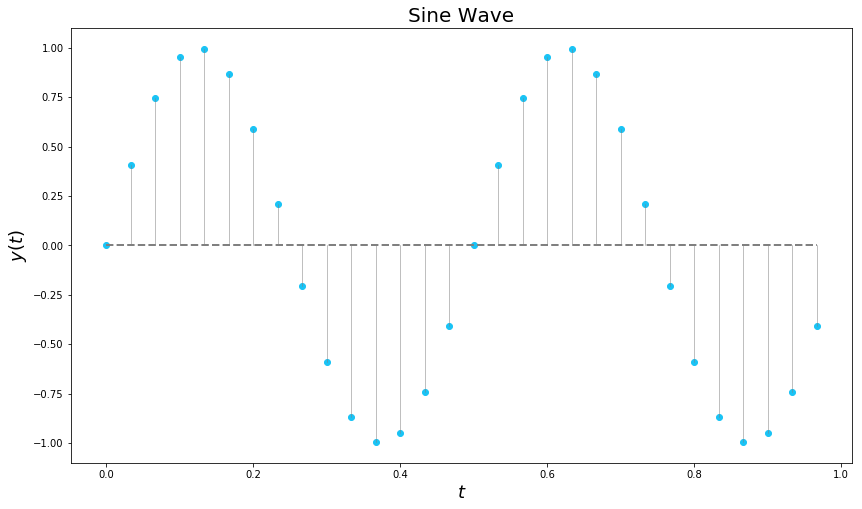

In [4]:
# Set the signal properties.
sampling_rate = 30.0
frequency = 2

# Set a range of t values from 0 to 1 spaced according to the sampling rate.
t = np.arange(0, 1, 1.0 / sampling_rate)

# Get the corresponding y values.
y = np.sin(2 * np.pi * frequency * t)

# Plot signal
plot.stem_plot(y, x_vals=t, title='Sine Wave', imag=False, ylim=(-1.1, 1.1), xlab='$t$', ylab='$y(t)$')

We can clearly see that the signal is not sparse as the majority of coefficients are non-zero.

### <font color='blue'>Discrete Fourier Transform</font>

We can transform our signal using the Discrete Fourier Transform (DFT) in order to examine its frequency components.

$$F_k = \sum_{k=0}^{N-1}f_n e^{-i2\pi kn/N}$$

In [5]:
# Calculate the DFT of a given signal
def dft(data):

    data = np.asarray(data, dtype=float)
    N = data.size
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    
    return np.dot(M, data)

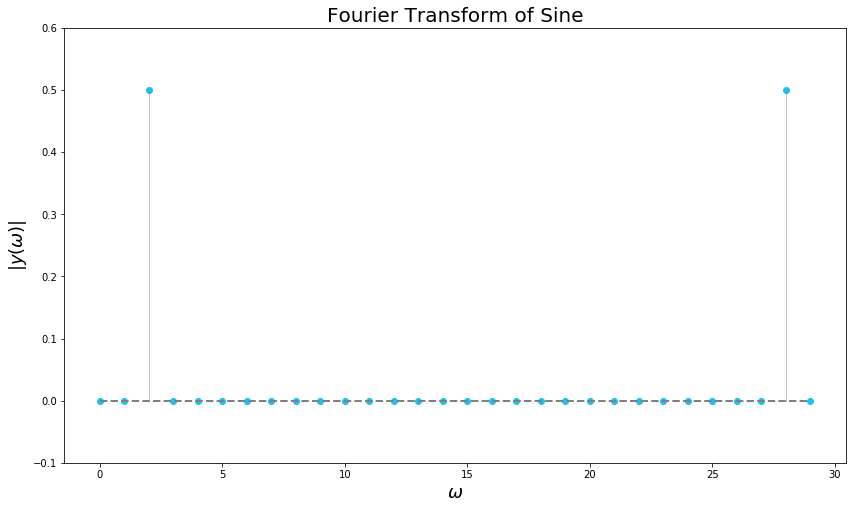

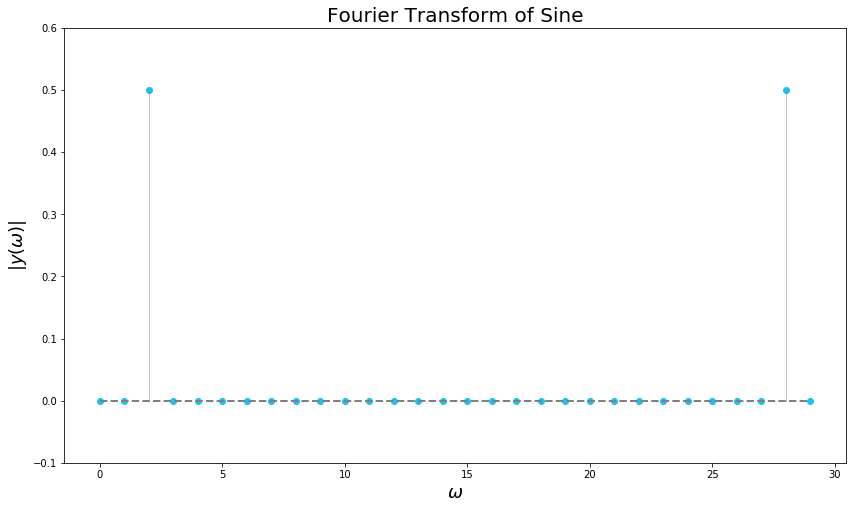

In [7]:
a1 = np.abs(np.fft.fft(y)) / y.size 
b1 = np.abs(dft(y)) / y.size 

plot.stem_plot(a1, title='Fourier Transform of Sine', imag=False, ylim=(-0.1, 0.6),
               xlab='$\omega$', ylab='$|y(\omega)|$')
plot.stem_plot(b1, title='Fourier Transform of Sine', imag=False, ylim=(-0.1, 0.6),
               xlab='$\omega$', ylab='$|y(\omega)|$')

In [ ]:
# Get the frequency range.
w = np.fft.fftshift(np.fft.fftfreq(t.size, 1 / sampling_rate))

# Calculate the normalised FFT of the signal.
y_fft = np.abs(np.fft.fftshift(np.fft.fft(y))) / y.size 

# Plot signal
plot.stem_plot(y_fft, x_vals=w, title='Fourier Transform of Sine', imag=False, ylim=(-0.1, 0.6),
               xlab='$\omega$', ylab='$|y(\omega)|$')

Now, we have only two coefficients which are non-zero. So, although in its natural domain our signal does not appear to be sparse, we were able to find a sparse representation in a different basis.

So, how can the knowledge that a given signal is sparse in a given domain be useful?

---

## Sparsity

We can use the knowledge that a signal is sparse in a given domain as prior knowledge when solving an inverse problem. This enables us to reduce the parameter space and allows us to converge upon a better and simpler solution.



### <font color='blue'>Sparse Representation</font>

A signal $x$ can be respresented as

$$x = \phi\alpha = \sum_{i=1}^n\phi_i\alpha_i$$

where $\alpha$ are the sparse coefficients of $x$ in the dictionary $\phi$ and $n$ is the sparsity of the signal. Each $\phi_i$ corresponds to an *atom* of the dictionay $\phi$. In the case of Fourier decomposition the atoms are sinusoids and when $\phi$ is a matrix the atoms are the columns of the matrix.

### <font color='blue'>Measures of Sparsity</font>

The true sparsity of a signal can be measured with the $l_0$ pseudo-norm.

$$\|x\|_0 = \text{Card}(\text{Supp}(x))$$

*i.e.* the number of non-zero elements in the signal. However, this function is non-convex and is computationally hard  to solve. Therefore, in practice the convex $l_1$ norm is used instead.

$$\|x\|_1 = \sum_{i=1}^n |x_i|$$

The $l_1$ norm is the closest convex norm to $l_0$ and Donoho and Huo (1999) have shown that for sufficiently sparse signals the two norms are equivalent.

We can use this to measure the sparsity of our time-frequency example.

In [ ]:
# Function to measure the l1 norm.
def l1_norm(signal):
    
    return np.sum(np.abs(signal))

# Get the l1 norm of the time and frequency signals.
print('The l1 norm of the time signal:', l1_norm(y))
print('The l1 norm of the frequency signal:', l1_norm(y_fft))

As expected the frequency signal is significantly more sparse.

### <font color='blue'>Promoting Sparsity</font>

In order to actually produce solutions that are more sparse one typically performs a soft thresholding operation in the sparse domain.

Here we introduce the the soft thresholding operator and compare it with a more commonly known hard thresholding operator.

**Hard Thresholding**

$$HT_{\lambda}(x_i) = \begin{cases} x_i & \text{if}\ |x_i| \geq \lambda \\  0 & \text{otherwise} \\ \end{cases}$$

**Soft Thresholding**

$$ST_{\lambda}(x_i) = \begin{cases} x_i - \lambda\text{sign}(x_i) & \text{if}\ |x_i| \geq \lambda \\  0 & \text{otherwise} \\ \end{cases}$$

The threshold value, $\lambda$, will vary depending on the type of problem. In the case of denoising $\lambda$ represents an estimate of the noise in the sparse domain. 

In [ ]:
# Function for performing hard thresholding.
def hard_thresh(signal, threshold):
    
    return signal * (np.abs(signal) >= threshold)

# Function for performing soft thresholding.
def soft_thresh(signal, threshold):
    
    return np.sign(signal) * (np.abs(signal) - threshold) * (np.abs(signal) >= threshold)

# Define a random signal.
np.random.seed(2)
x = np.random.ranf((5, 5))

# Set the threshold.
thresh = 0.6

# Threshold the signal.
x_thresh_hard = hard_thresh(x, thresh)
x_thresh_soft = soft_thresh(x, thresh)

print('Original Signal.')
print('')
print(x)
print('')
print('l1 norm:', l1_norm(x))
print('')
print('')
print('Hard Thresholded Signal.')
print('')
print(x_thresh_hard)
print('')
print('l1 norm:', l1_norm(x_thresh_hard))
print('')
print('')
print('Soft Thresholded Signal.')
print('')
print(x_thresh_soft)
print('')
print('l1 norm:', l1_norm(x_thresh_soft))


### <font color='blue'>Sparse Regularisation</font>

Recall that for solving an inverse problem of the form

$$y = Hx$$

we aimed to minimise a function of the following form

$$\begin{aligned} & \underset{X}{\text{argmin}} & \frac{1}{2}\|y-Hx\|_2^2\end{aligned}$$

Now, if we know that $x$ is sparse in the domain $x = \phi\alpha$ we can update our minimisation problems as follows:

$$\begin{aligned} & \underset{\alpha}{\text{argmin}} & \frac{1}{2}\|y-H\phi\alpha\|_2^2 + \lambda\|\alpha\|_1\end{aligned}$$

where we now seek a value of $\alpha$ that both minimises the residual and requires that $\alpha$ be sparse. This formulation is generally referred to as a *synthesis prior*. This problem can alternatively be formulated as follows:

$$\begin{aligned} & \underset{x}{\text{argmin}} & \frac{1}{2}\|y-Hx\|_2^2 + \lambda\|\phi^{T}x\|_1\end{aligned}$$

which is referred to as an *analysis prior*. When $\phi$ is orthogonal these two formulations are equivalent, when $\phi$ is not orthogonal this is no longer the case. Each approach has certain benefits when applied to different problems.

---

## <font color="red">Denoising Exercise</font>

This exercise provides a simple demonstration of how sparse representations of signals can be extremely useful. The objective is to recover the original signal from a noisy observation by denoising it in a sparse domain.

Let's start by looking at the signal, a basic cosine function.

In [ ]:
#############################
# NO NEED TO EDIT THIS CELL #
# JUST EXECUTE IT           #
#############################

# Define a range of values
t = np.linspace(0, 22 * np.pi, 1000, endpoint=False)

# Set the noise level.
sigma = 3.0

# Define the signal.
x = np.cos(t + 11 * np.pi / 1000)

# Add noise to the signal.
y = x + sigma * np.random.randn(x.size)

plot.line_plot(x, title='True Signal')
plot.line_plot(y, title='Noisy Observation')

**Choose a sparse domain**

Your first task is to identify an appropriate sparse domain for the signals.

<br />
<font color='red'>EDIT THE CELL BELOW</font>

In [ ]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# Define the sparse representations of the signals.
x_sparse = fft(x)
y_sparse = fft(y)

Now we can have a look at the siganls in the sparse domain you used.

In [ ]:
#############################
# NO NEED TO EDIT THIS CELL #
# JUST EXECUTE IT           #
#############################

plot.line_plot(np.abs(x_sparse), title='True Signal in Sparse Domain')
plot.line_plot(np.abs(y_sparse), title='Noisy Observation in Sparse Domain')

Can you identify and similarities between the original and noisy signals in the sparse domain?

If not, you may want to rethink your choice.

**Denoise the signal**

Your next task is to estimate the noise level of the noisy signal in the sparse domain and remove it.

<br />
<font color='red'>EDIT THE CELL BELOW</font>

In [ ]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# Estimate the noise in the sparse domain.
noise_est = 3 * sigma_mad(y_sparse) 
print('Noise Estimate =', noise_est)

# Perform hard thresholding.
x_rec = ifft(hard_thresh(y_sparse, noise_est))

Now let's look at what you have recovered.

In [ ]:
#############################
# NO NEED TO EDIT THIS CELL #
# JUST EXECUTE IT           #
#############################

plot.line_plot(np.real(x_rec), title='Denoised Signal')

Did it work? 

If you signal is still a bit noisy try increasing the noise threshold by a factor *e.g.* $n = 3$ or $n = 4$.

---

## <font color='orange'>Hints</font>

** Denoising Exercise Hints **

1. For your sparse representation you may want to use soemthing *fast and f(o)urious*.
1. Try not to get *mad* when estimating the noise.
1. Thresholding signals can be quite *hard*.
1. Make sure you theshold in the correct domain.
1. Make sure your recovered signal is the correct domain.

---

## Exercise Solutions

**<font color="red">Warning!</font>** Try your best to solve all of the exercises on your own before checking the answers.

<br />

### Denoising Exercise Solution

```Python

# Define the sparse representations of the signals.
x_sparse = fft(x)
y_sparse = fft(y)

# Estimate the noise in the sparse domain.
noise_est = 3 * sigma_mad(y_sparse) 

# Perform hard thresholding.
x_rec = ifft(hard_thresh(y_sparse, noise_est))

```